# `tau_learn`: An alternative to learning rates

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import nengo
import numpy as np

Learning rates are very annoying to set, and when you change aspects of a model, that can completely change what a good learning rate is.

To demonstrate this, let's consider an extremely simple case where we have constant activity in a network and we're just learning one target output value, using delta-rule.  Here's a simple network implementing this.

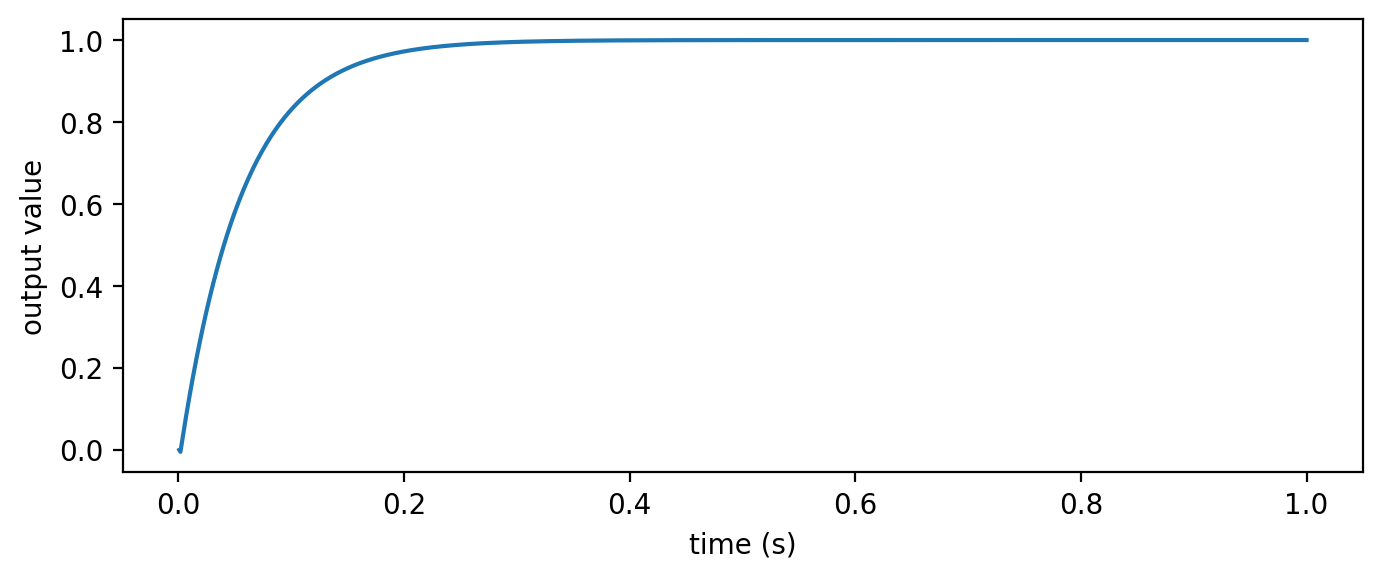

In [3]:
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=100, dimensions=1, 
                         max_rates=nengo.dists.Uniform(200,400), 
                         neuron_type=nengo.LIFRate())
    target = nengo.Node(1)
    output = nengo.Node(None, size_in=1)
    error = nengo.Node(None, size_in=1)
    learn_conn = nengo.Connection(ens, output, 
                                  learning_rule_type=nengo.PES(learning_rate=1e-3, pre_synapse=None), 
                                  synapse=0)
    nengo.Connection(output, error, synapse=None)
    nengo.Connection(target, error, synapse=None, transform=-1)
    nengo.Connection(error, learn_conn.learning_rule, synapse=None)
    p = nengo.Probe(output)
sim = nengo.Simulator(model, progress_bar=None)
with sim:
    sim.run(1.0)
plt.figure(figsize=(8,3), dpi=200)
plt.plot(sim.trange(), sim.data[p])
plt.xlabel('time (s)')
plt.ylabel('output value')
plt.show()


If we change the learning rate, it will learn faster or slower:

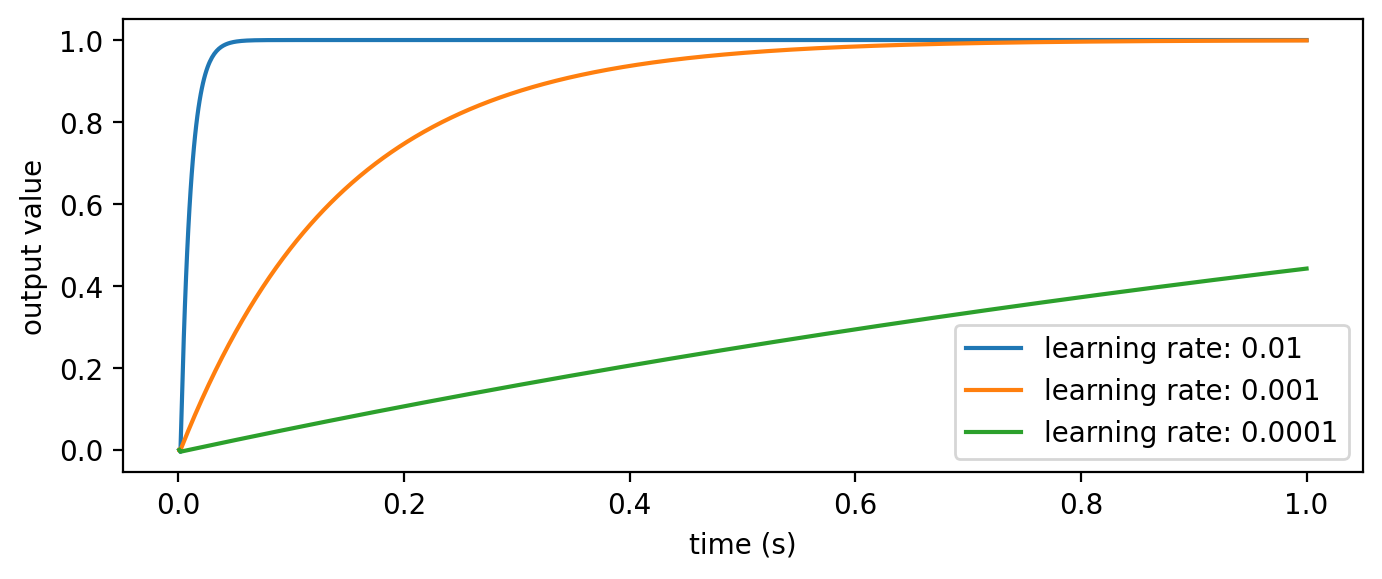

In [4]:
plt.figure(figsize=(8,3), dpi=200)
for learning_rate in [1e-2, 1e-3, 1e-4]:
    model = nengo.Network()
    with model:
        ens = nengo.Ensemble(n_neurons=100, dimensions=1, 
                             max_rates=nengo.dists.Uniform(200,400), 
                             neuron_type=nengo.LIFRate(tau_ref=0))
        target = nengo.Node(1)
        output = nengo.Node(None, size_in=1)
        error = nengo.Node(None, size_in=1)
        learn_conn = nengo.Connection(ens, output, 
                                      learning_rule_type=nengo.PES(learning_rate=learning_rate, pre_synapse=None), 
                                      synapse=0)
        nengo.Connection(output, error, synapse=None)
        nengo.Connection(target, error, synapse=None, transform=-1)
        nengo.Connection(error, learn_conn.learning_rule, synapse=None)
        p = nengo.Probe(output)
    sim = nengo.Simulator(model, progress_bar=None)
    with sim:
        sim.run(1.0)
    plt.plot(sim.trange(), sim.data[p], label=f'learning rate: {learning_rate}')
plt.xlabel('time (s)')
plt.ylabel('output value')
plt.legend()
plt.show()

But we can also change how quickly it learns by changing neuron properties.  Here, we change the maximum output of the neuron (i.e. the "firing rate" for a rate-mode neuron).

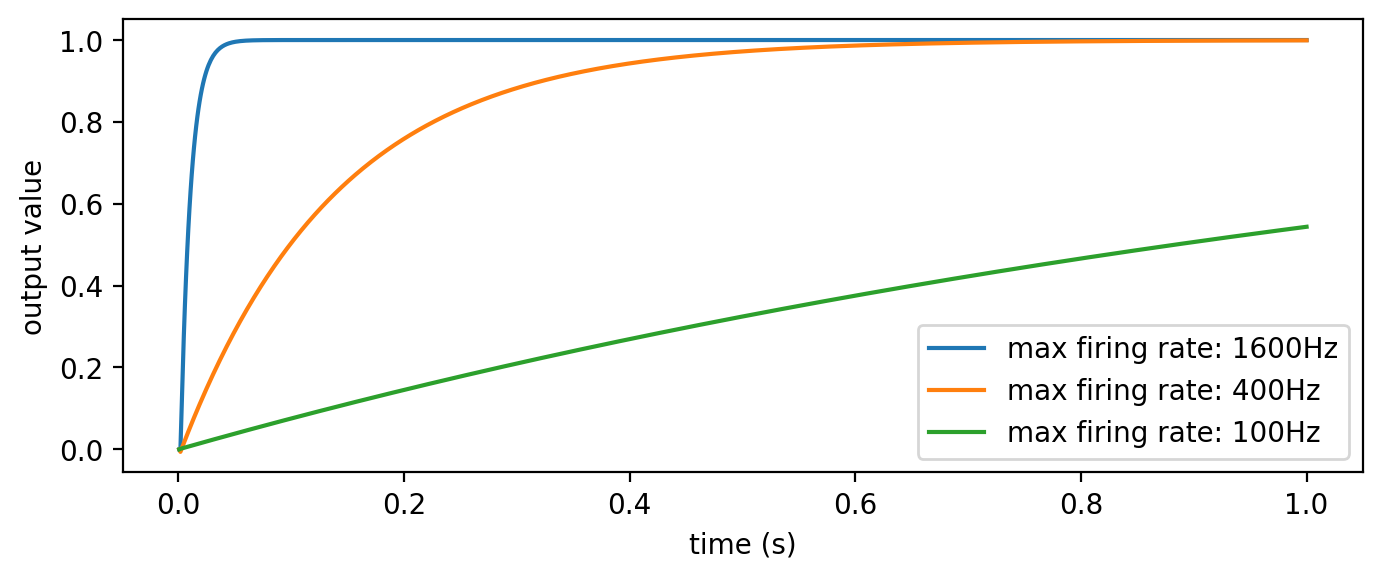

In [5]:
plt.figure(figsize=(8,3), dpi=200)

for max_rate in [1600, 400, 100]:
    model = nengo.Network()
    with model:
        ens = nengo.Ensemble(n_neurons=100, dimensions=1, 
                             max_rates=nengo.dists.Uniform(max_rate/2, max_rate), 
                             neuron_type=nengo.LIFRate(tau_ref=0))
        target = nengo.Node(1)
        output = nengo.Node(None, size_in=1)
        error = nengo.Node(None, size_in=1)
        learn_conn = nengo.Connection(ens, output, 
                                      learning_rule_type=nengo.PES(learning_rate=1e-3, pre_synapse=None), 
                                      synapse=0)
        nengo.Connection(output, error, synapse=None)
        nengo.Connection(target, error, synapse=None, transform=-1)
        nengo.Connection(error, learn_conn.learning_rule, synapse=None)
        p = nengo.Probe(output)
    sim = nengo.Simulator(model, progress_bar=None)
    with sim:
        sim.run(1.0)
    plt.plot(sim.trange(), sim.data[p], label=f'max firing rate: {max_rate}Hz')
plt.xlabel('time (s)')
plt.ylabel('output value')
plt.legend()
plt.show()

This is aggravating, especially since it's not exactly obvious what the relationship is between the neuron properties and the overall effective learning rate (i.e. how long it takes to hit a target output value).

So, let's try some math.

## Derivation

We have a situation where there is some vector $x$ and we're multiplying it by some weights $w$ to produce an output $y$

$ y = x \cdot w $

In these situations, a common learning rule is the delta rule, where $t$ is some target value

$ \Delta w = -\alpha x (y - t) $

Let's write that in continuous time (we can always discretize later)

$ {dw \over dt} = -\alpha x (y - t) $

$ {dw \over dt} = -\alpha x (x \cdot w - t) $

However, this differential equation tells us about the dynamics of the weights changing.  In the case shown above, we don't really care about the dynamics of $w$ -- we are interested in the dynamics of $y$.  So let's find an expression for ${dy \over dt}$.

$ {dy \over dt} = {dy \over dw} {dw \over dt}$

$ {dy \over dt} = x \cdot {dw \over dt}$

$ {dy \over dt} = -x \cdot \alpha x (y - t)$

$ {dy \over dt} = -x \cdot x \alpha(y - t)$

$ {dy \over dt} = -||x||^2 \alpha(y - t)$

$ {dy \over dt} = -||x||^2 \alpha (y - t)$

$ {1 \over {||x||^2 \alpha}}{dy \over dt} = -(y - t)$

This is a standard differential equation that we know the synamics for.  It will end up as $y=1-e^{-t/\tau}$, where $\tau$ is $ {1 \over {||x||^2 \alpha}} $.  In general, this tells us that $y$ will converge towards the value  $t$ with a time constant of $ {1 \over {||x||^2 \alpha}} $

Let's define that as a new parameter:

$\tau_{learn} = {1 \over {||x||^2 \alpha}} $

This means that, if we want our learning to converge with a given time constant $\tau_{learn}$, we should set $\alpha$ to

$\alpha = {1 \over {||x||^2 \tau_{learn}}} $

## Testing the rule

Let's try implementing a learning rule that uses $\tau_{learn}$ rather than a traditional learning rate.  Since we're working with Nengo, we'll do this by implementing a custom `Process` that handles the learning rule.  It has two inputs ($x$ and the error value $y-t$), and one output $y$.  

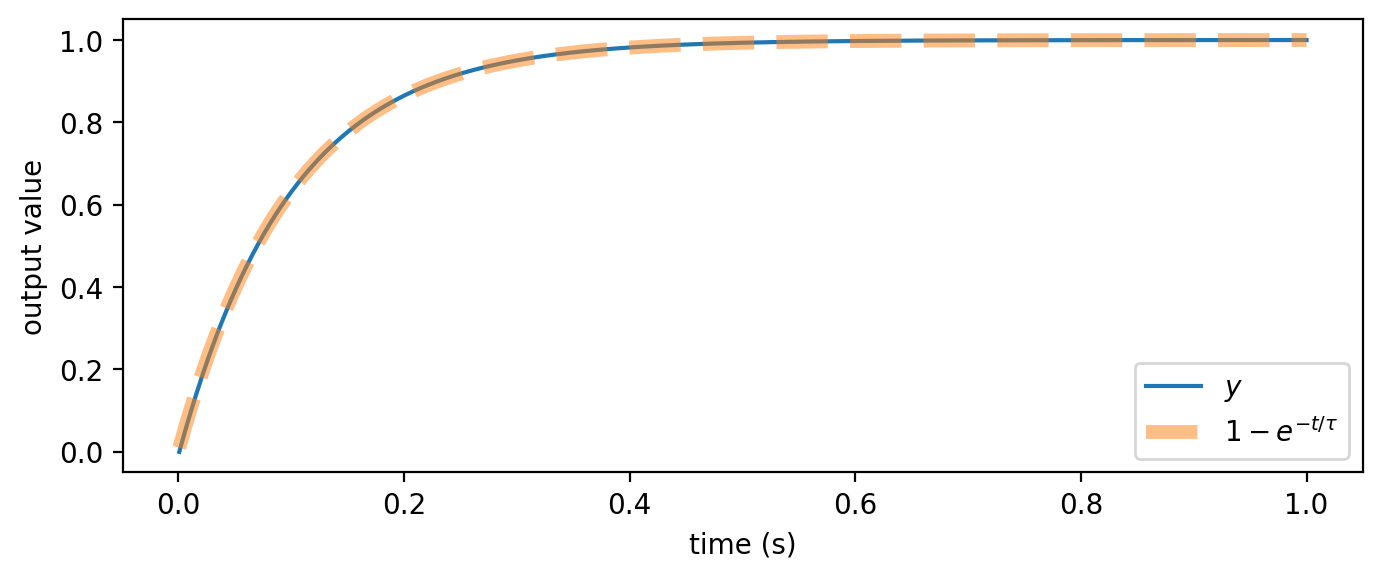

In [6]:
class TauLearnPES(nengo.Process):
    def __init__(self, tau_learn, size_pre, size_post):
        self.tau_learn = tau_learn
        self.size_pre = size_pre
        self.size_post = size_post
        
        super().__init__(default_size_in=size_pre+size_post,
                         default_size_out=size_post)        

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        w = np.zeros((self.size_post, self.size_pre))

        # this is the code that will be run each time step
        def step_learn(t, x, w=w, tau_learn=self.tau_learn):
            x, error = x[:self.size_pre], x[self.size_pre:]
            
            norm2 = np.sum(x**2)
            if norm2 > 0:
                alpha = 1.0/(norm2*tau_learn)
                w += -alpha*np.outer(error, x)*dt
                
            return np.dot(w, x)
        return step_learn


model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=100, dimensions=1, max_rates=nengo.dists.Uniform(200,400), neuron_type=nengo.LIFRate())
    target = nengo.Node(1)
    output = nengo.Node(None, size_in=1)
    error = nengo.Node(None, size_in=1)
    
    learn = nengo.Node(TauLearnPES(tau_learn=0.1, size_pre=ens.n_neurons, size_post=1))
    nengo.Connection(ens.neurons, learn[:ens.n_neurons], synapse=None)
    nengo.Connection(learn, output, synapse=None)
    nengo.Connection(output, error, synapse=None)
    nengo.Connection(target, error, synapse=None, transform=-1)
    nengo.Connection(error, learn[ens.n_neurons:], synapse=0)
    p = nengo.Probe(output)
sim = nengo.Simulator(model, progress_bar=None)
with sim:
    sim.run(1.0)
plt.figure(figsize=(8,3), dpi=200)
plt.plot(sim.trange(), sim.data[p], label='$y$')
plt.plot(sim.trange(), 1-np.exp(-sim.trange()/0.1), lw=5, ls='--', alpha=0.5, label='$1-e^{-t/\\tau}$')
plt.xlabel('time (s)')
plt.ylabel('output value')
plt.legend()
plt.show()


It works!  It learns and it exactly follows the desired trajectory.  Let's try a few different $\tau$ values:

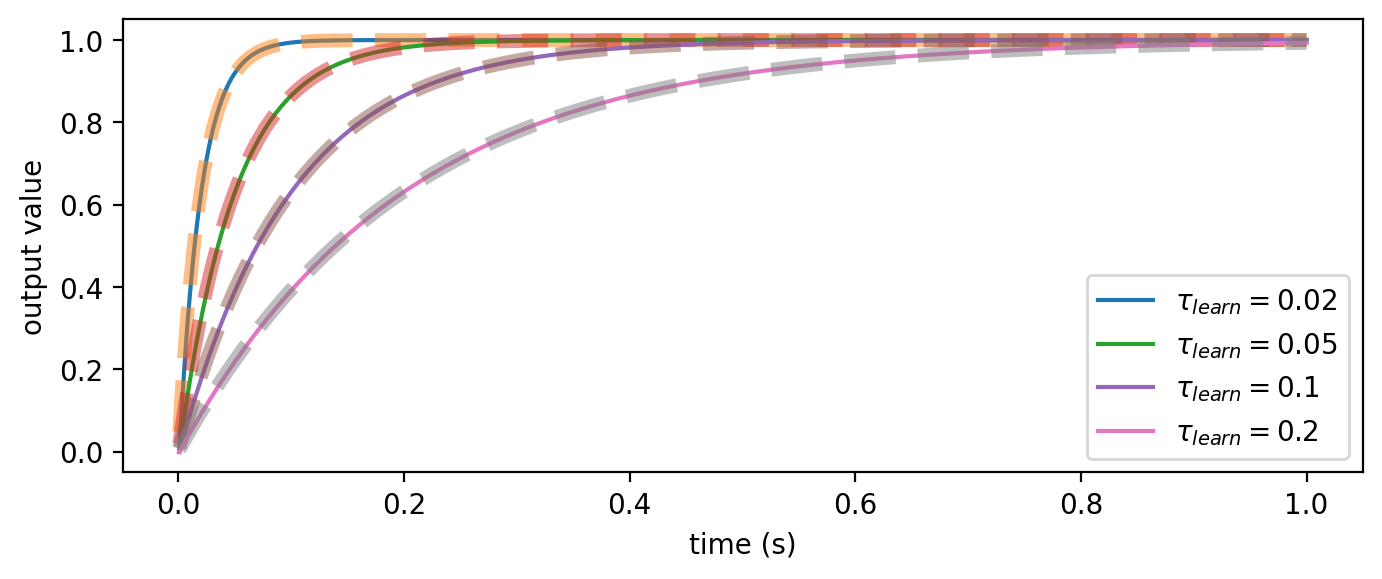

In [7]:
plt.figure(figsize=(8,3), dpi=200)

for tau_learn in [0.02, 0.05, 0.1, 0.2]:
    model = nengo.Network()
    with model:
        ens = nengo.Ensemble(n_neurons=100, dimensions=1, max_rates=nengo.dists.Uniform(200,400), neuron_type=nengo.LIFRate())
        target = nengo.Node(1)
        output = nengo.Node(None, size_in=1)
        error = nengo.Node(None, size_in=1)

        learn = nengo.Node(TauLearnPES(tau_learn=tau_learn, size_pre=ens.n_neurons, size_post=1))
        nengo.Connection(ens.neurons, learn[:ens.n_neurons], synapse=None)
        nengo.Connection(learn, output, synapse=None)
        nengo.Connection(output, error, synapse=None)
        nengo.Connection(target, error, synapse=None, transform=-1)
        nengo.Connection(error, learn[ens.n_neurons:], synapse=0)
        p = nengo.Probe(output)
    sim = nengo.Simulator(model, progress_bar=None)
    with sim:
        sim.run(1.0)
    plt.plot(sim.trange(), sim.data[p], label=f'$\\tau_{{learn}}={tau_learn}$')
    plt.plot(sim.trange(), 1-np.exp(-sim.trange()/tau_learn), lw=5, ls='--', alpha=0.5)
plt.xlabel('time (s)')
plt.ylabel('output value')
plt.legend()
plt.show()


How well does this work for different `dt` values?  After all, in the code we're discretizing the differential equation, and we're just doing a forward Euler step.  So it'll probably be a bit wrong for large `dt`.

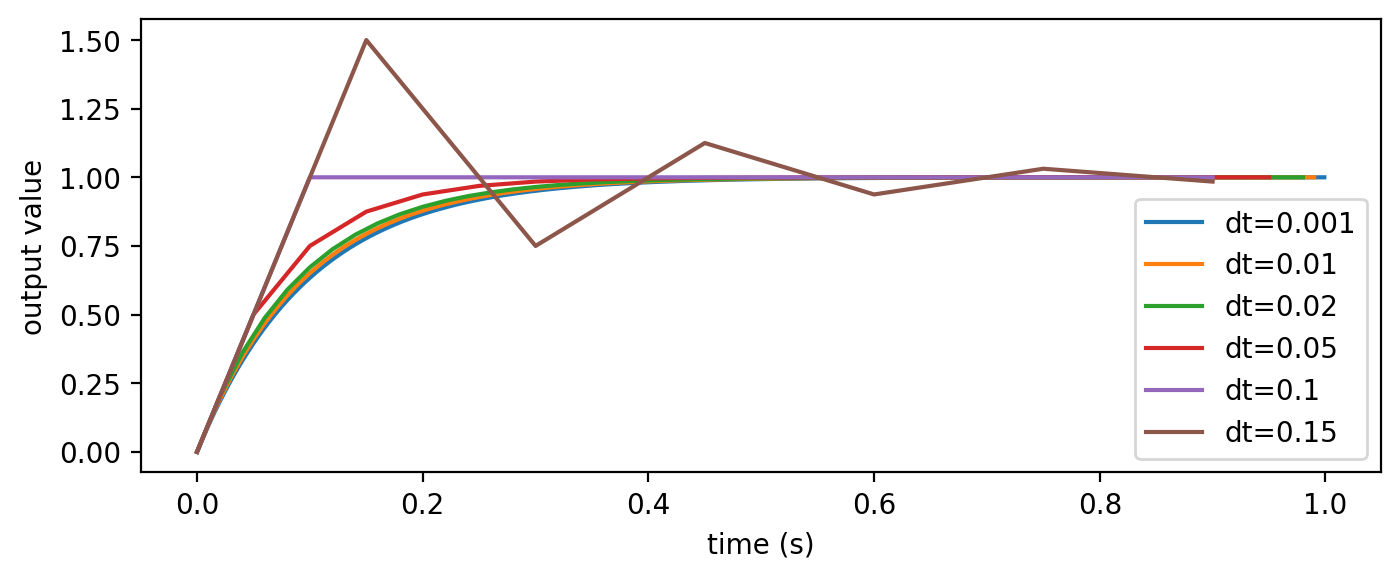

In [8]:
plt.figure(figsize=(8,3), dpi=200)

model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=100, dimensions=1, max_rates=nengo.dists.Uniform(200,400), neuron_type=nengo.LIFRate())
    target = nengo.Node(1)
    output = nengo.Node(None, size_in=1)
    error = nengo.Node(None, size_in=1)
    
    learn = nengo.Node(TauLearnPES(tau_learn=0.1, size_pre=ens.n_neurons, size_post=1))
    nengo.Connection(ens.neurons, learn[:ens.n_neurons], synapse=None)
    nengo.Connection(learn, output, synapse=None)
    nengo.Connection(output, error, synapse=None)
    nengo.Connection(target, error, synapse=None, transform=-1)
    nengo.Connection(error, learn[ens.n_neurons:], synapse=0)
    p = nengo.Probe(output)

for dt in [0.001, 0.01, 0.02, 0.05, 0.1, 0.15]:
    sim = nengo.Simulator(model, progress_bar=None, dt=dt)
    with sim:
        sim.run(1.0)
    plt.plot(sim.trange()-dt, sim.data[p], label=f'dt={dt}')  # subtracting dt because nengo doesn't use the first time step
plt.xlabel('time (s)')
plt.ylabel('output value')
plt.legend()
plt.show()

That's horrible for very large $dt$ (for $dt>\tau_{learn}$, it overshoots!), but even for $dt$ values getting near $\tau_{learn}$ it's not following the curve correctly.  

Fortunately, we can fix this!  Since this is a nice pretty exponential curve, we can discretize using the zero-order-hold trick.  In this case, all we have to do is replace $dt/\tau$ with $(1-e^{-dt/\tau})$.

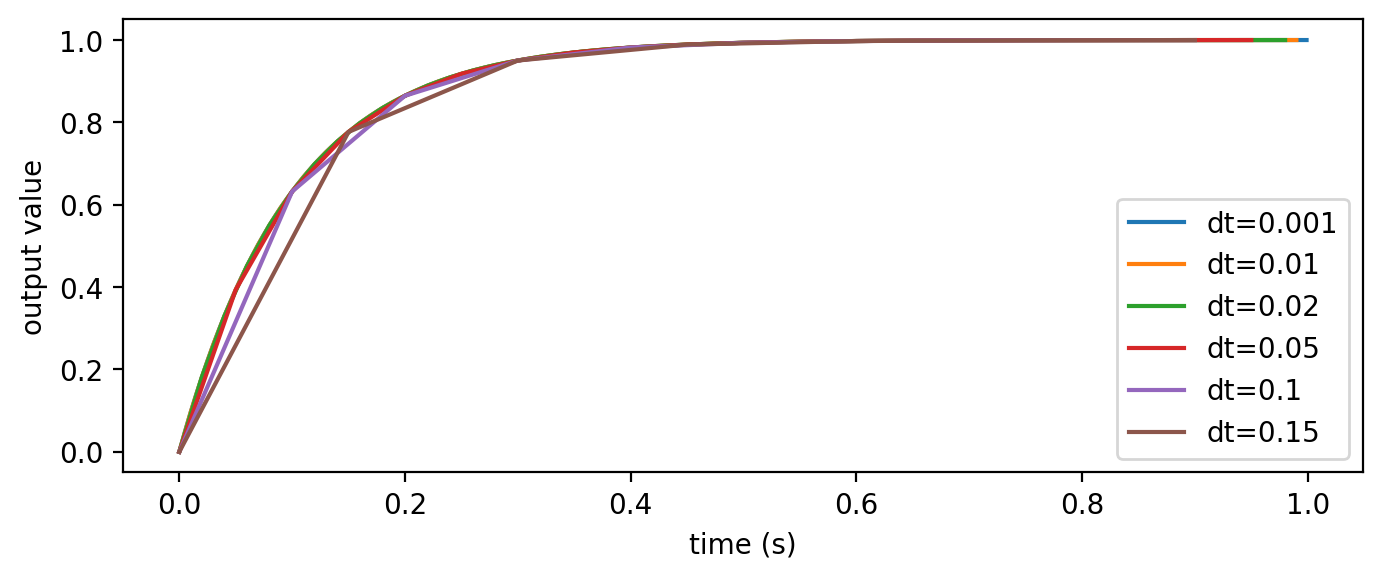

In [9]:
class TauLearnPES(nengo.Process):
    def __init__(self, tau_learn, size_pre, size_post):
        self.tau_learn = tau_learn
        self.size_pre = size_pre
        self.size_post = size_post
        
        super().__init__(default_size_in=size_pre+size_post,
                         default_size_out=size_post)        

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        w = np.zeros((self.size_post, self.size_pre))
        scale = (1-np.exp(-dt/self.tau_learn))

        def step_learn(t, x, w=w, scale=scale):
            x, error = x[:self.size_pre], x[self.size_pre:]
            
            norm2 = np.sum(x**2)
            if norm2 > 0:
                alpha = scale/norm2
                
                w += -alpha*np.outer(error, x)
                
            return np.dot(w, x)
        return step_learn


model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=100, dimensions=1, max_rates=nengo.dists.Uniform(200,400), neuron_type=nengo.LIFRate())
    target = nengo.Node(1)
    output = nengo.Node(None, size_in=1)
    error = nengo.Node(None, size_in=1)
    
    learn = nengo.Node(TauLearnPES(tau_learn=0.1, size_pre=ens.n_neurons, size_post=1))
    nengo.Connection(ens.neurons, learn[:ens.n_neurons], synapse=None)
    nengo.Connection(learn, output, synapse=None)
    nengo.Connection(output, error, synapse=None)
    nengo.Connection(target, error, synapse=None, transform=-1)
    nengo.Connection(error, learn[ens.n_neurons:], synapse=0)
    p = nengo.Probe(output)

plt.figure(figsize=(8,3), dpi=200)
for dt in [0.001, 0.01, 0.02, 0.05, 0.1, 0.15]:
    sim = nengo.Simulator(model, progress_bar=None, dt=dt)
    with sim:
        sim.run(1.0)
    plt.plot(sim.trange()-dt, sim.data[p], label=f'dt={dt}')
plt.xlabel('time (s)')
plt.ylabel('output value')
plt.legend()
plt.show()


This now follows the desired curve perfectly!


## The main drawback

While this learning rule is nifty, it has a big drawback: it is no longer a local learning rule.  We have to divide by $||x||^2$, and to compute that we need data from the entire vector.  For some applications, this is a problem.

So, to address this, we can simply pre-compute an expected value of $||x||^2$, and use that instead.  If we do this, then our learning rule is now back to a completely normal form, and we can go back to using a built-in learning rule, rather than implementing our own.

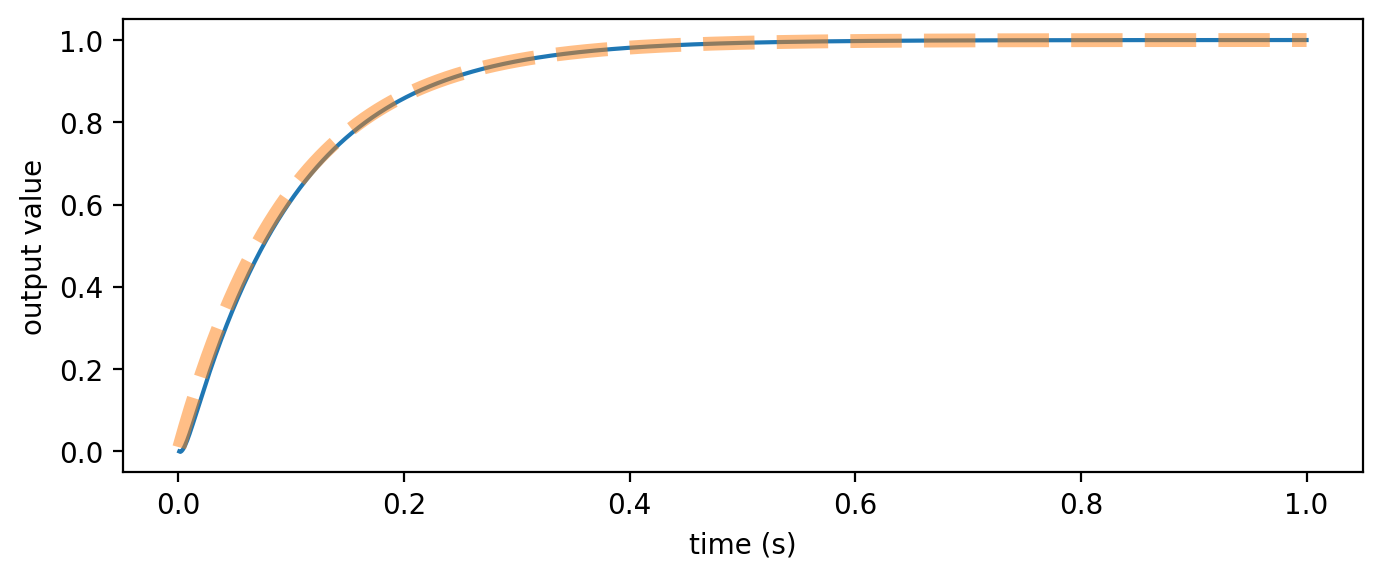

In [10]:
def compute_expected_norm2(ens, inputs):
    model = nengo.Network(add_to_container=False)
    model.ensembles.append(ens)
    sim = nengo.Simulator(model, progress_bar=None)
    _, a = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=inputs)
    n = np.sum(a**2, axis=1)
    return np.mean(n)
    

model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=100, dimensions=1, 
                         max_rates=nengo.dists.Uniform(200,400), 
                         neuron_type=nengo.LIFRate(),
                         seed=2)
    norm2=compute_expected_norm2(ens, inputs=[[0]])    
    
    dt = 0.001
    tau_learn = 0.1
    scale = (1-np.exp(-dt/tau_learn))
    alpha = scale / norm2 
    
    target = nengo.Node(1)
    output = nengo.Node(None, size_in=1)
    error = nengo.Node(None, size_in=1)
    learn_conn = nengo.Connection(ens, output, 
                                  # we have to mutliply by n_neurons and divide by dt because in the nengo implementation
                                  # of the PES learning rule, it multiplies by dt/n_neurons.  This was to keep the
                                  # learning rule performing the same as you change dt and n_neurons.  Note that this
                                  # can be thought of as a simplistic attempt at implementing the new rule we have here!
                                  learning_rule_type=nengo.PES(learning_rate=alpha*ens.n_neurons/dt), 
                                  synapse=0)
    nengo.Connection(output, error, synapse=None)
    nengo.Connection(target, error, synapse=None, transform=-1)
    nengo.Connection(error, learn_conn.learning_rule, synapse=None)
    p = nengo.Probe(output)
sim = nengo.Simulator(model, progress_bar=None)
with sim:
    sim.run(1.0)
plt.figure(figsize=(8,3), dpi=200)
plt.plot(sim.trange(), sim.data[p])
plt.plot(sim.trange(), 1-np.exp(-sim.trange()/0.1), lw=5, ls='--', alpha=0.5, label='$1-e^{-t/\\tau}$')

plt.xlabel('time (s)')
plt.ylabel('output value')
plt.show()


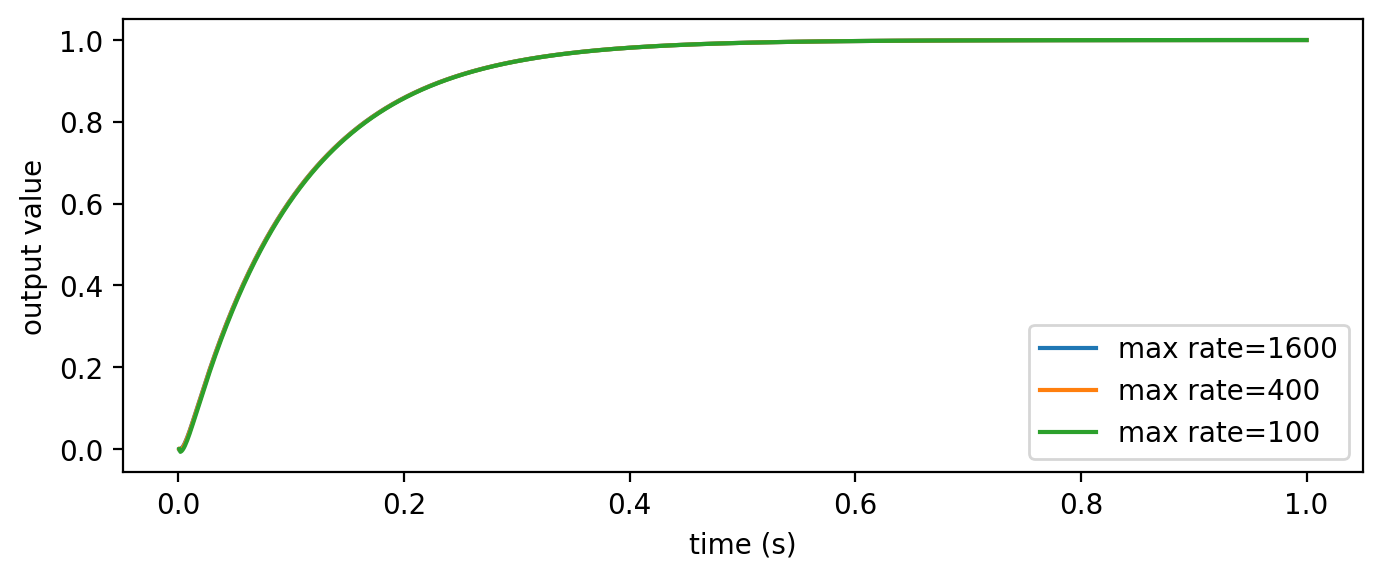

In [11]:
plt.figure(figsize=(8,3), dpi=200)

for max_rate in [1600, 400, 100]:
    model = nengo.Network()
    with model:
        ens = nengo.Ensemble(n_neurons=100, dimensions=1, 
                             max_rates=nengo.dists.Uniform(max_rate/2,max_rate), 
                             neuron_type=nengo.LIFRate(tau_ref=0),
                             seed=2)
        norm2=compute_expected_norm2(ens, inputs=[[0]])    

        dt = 0.001
        tau_learn = 0.1
        scale = (1-np.exp(-dt/tau_learn))
        alpha = scale / norm2 

        target = nengo.Node(1)
        output = nengo.Node(None, size_in=1)
        error = nengo.Node(None, size_in=1)
        learn_conn = nengo.Connection(ens, output, 
                                      learning_rule_type=nengo.PES(learning_rate=alpha*ens.n_neurons/dt), 
                                      synapse=0)
        nengo.Connection(output, error, synapse=None)
        nengo.Connection(target, error, synapse=None, transform=-1)
        nengo.Connection(error, learn_conn.learning_rule, synapse=None)
        p = nengo.Probe(output)
    sim = nengo.Simulator(model, progress_bar=None)
    with sim:
        sim.run(1.0)
    plt.plot(sim.trange(), sim.data[p], label=f'max rate={max_rate}')

plt.xlabel('time (s)')
plt.ylabel('output value')
plt.legend()
plt.show()


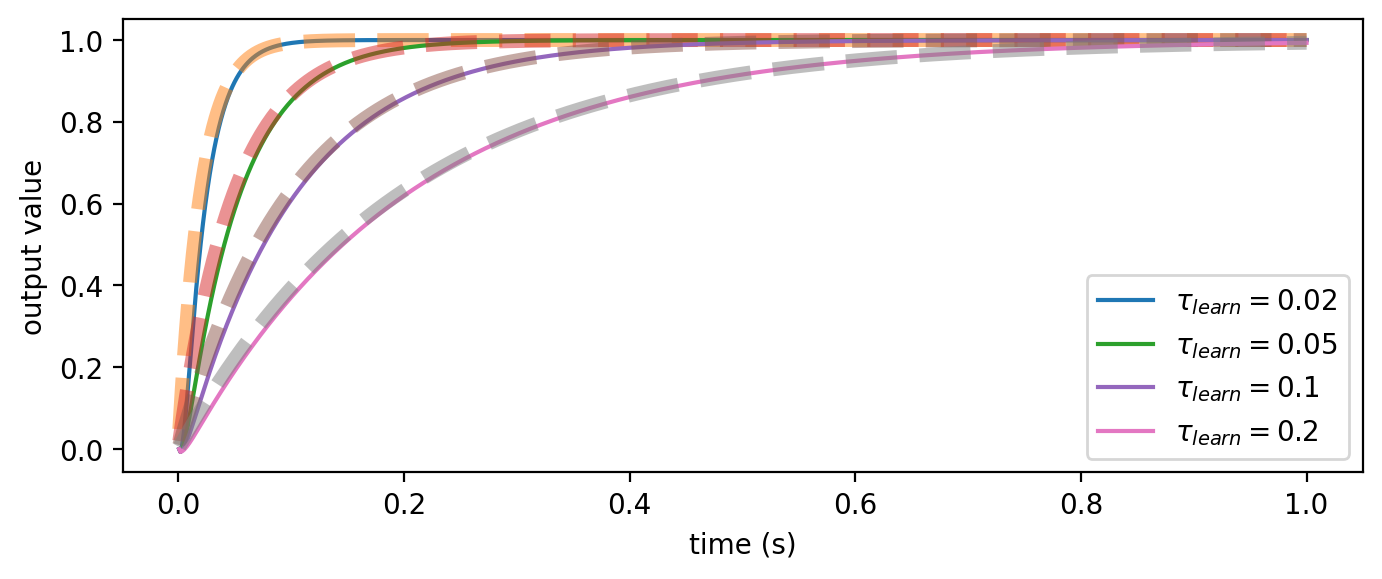

In [12]:
plt.figure(figsize=(8,3), dpi=200)

for tau_learn in [0.02, 0.05, 0.1, 0.2]:
    model = nengo.Network()
    with model:
        ens = nengo.Ensemble(n_neurons=100, dimensions=1, 
                             max_rates=nengo.dists.Uniform(max_rate/2,max_rate), 
                             neuron_type=nengo.LIFRate(tau_ref=0),
                             seed=2)
        norm2=compute_expected_norm2(ens, inputs=[[0]])    

        dt = 0.001
        scale = (1-np.exp(-dt/tau_learn))
        alpha = scale / norm2 

        target = nengo.Node(1)
        output = nengo.Node(None, size_in=1)
        error = nengo.Node(None, size_in=1)
        learn_conn = nengo.Connection(ens, output, 
                                      learning_rule_type=nengo.PES(learning_rate=alpha*ens.n_neurons/dt), 
                                      synapse=0)
        nengo.Connection(output, error, synapse=None)
        nengo.Connection(target, error, synapse=None, transform=-1)
        nengo.Connection(error, learn_conn.learning_rule, synapse=None)
        p = nengo.Probe(output)
    sim = nengo.Simulator(model, progress_bar=None)
    with sim:
        sim.run(1.0)
    plt.plot(sim.trange(), sim.data[p], label=f'$\\tau_{{learn}}={tau_learn}$')
    plt.plot(sim.trange(), 1-np.exp(-sim.trange()/tau_learn), lw=5, ls='--', alpha=0.5)

plt.xlabel('time (s)')
plt.ylabel('output value')
plt.legend()
plt.show()


Overall, this means that if you have a learning rate $\alpha$, you can turn it into a learning time $\tau_{learn}$ by setting:

$\alpha = {1 \over {||x||^2 \tau_{learn}}} $

where $||x||^2$ is either the actual squared L2 norm of the vector the weights are being applied to or the expected squared L2 norm of those same weights.